# ДЗ №3 
## Обучение моделей глубокого обучения на PyTorch

In [1]:
!pip3 install torch torchvision numpy matplotlib

Ваша задача на этой неделе - повторить модель трёхслойного перцептрона из прошолго задания на **PyTorch**, разобрать лучшие практики обучения моделей глубокого обучения и провести серию экспериментов

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple, List, Type, Dict, Any

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

Для того, чтобы эксперимент можно было повторить, хорошей практикой будет зафиксировать генератор случайных чисел. Также, рекоммендуется зафиксировать RNG в numpy и, если в качестве бэкенда используется cudnn - включить детерминированный режим.

Подробнее: https://pytorch.org/docs/stable/notes/randomness.html

In [3]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Модель

Основным способом организации кода на **Pytorch** является модуль. Простые модели могут быть реализованны из готовых модулей ( к примеру, `torch.nn.Sequential`, `torch.nn.Linear` и т.д. ), для более сложных архитектур часто приходтся реализовывать собственные блоки. Это достаточно легко сделать - достаточно написать класс, наследуемый от `torch.nn.Module` и реализующий метод `.forward`, который принимает и возвращает тензоры ( `torch.Tensor` ). Чаще всего этого достаточно и писать реализацию метода `backward` не нужно: за вас это сделает библиотека автоматического вычисления градиентов, реализованная в **Pytorch**.

Пример реализации кастомного модуля из официальной документации: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

Здесь нелишним будет напомнить, что в подходе, используемом в Pytorch, все обучаемые параметры модуля должны существовать как атрибуты экземпляра этого модуля. То есть, объекты, соответствующие исполняемым объектам (`callable`), содержащим обучаемые параметры модуля, должны быть атрибутами этого модуля (`self.xxx`) и должны быть созданы в методе `__init__()`. При этом применяться к данным они должны в методе `forward()` этого модуля.

#### Задание 1

Повторите реализацию трёхслойного перцептрона из предыдущего задания на **Pytorch**. Желательно также, чтобы реализация модели имела параметризуемую глубину ( количество слоёв ), количество параметров на каждом слое и функцию активации. Отсутствие такой возможности не снижает балл, но сильно поможет в освоении принципов построения нейросетей с применением библиотеки pytorch.

In [4]:
class Perceptron(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 input_channels: int = 1, 
                 hidden_layer_features: List[int] = [256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10):

        super().__init__()
        self.flatten = nn.Flatten()
        self.activation = activation
        
        self.linear_network = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        return self.linear_network(x)

Следующий код позволяет посмотреть архитектуру получившейся модели и общее количество обучаемых параметров. Мы хотим, чтобы количество параметров в модели было порядка сотен тысяч. Если у вас получается больше или меньше, попробуйте изменить архитектуру модели.

In [5]:
model = Perceptron()
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Perceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_network): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
    (5): ReLU()
  )
)
Total number of trainable parameters 269322


### Обучающая выборка

На практике, наиболее важным для успеха обучения любой модели машинного обучения является этап подготовки данных. Модели глубокого обучения не являются исключением. Большая, чистая, репрезентативная и релевантная поставленной задаче обучающая выборка часто важнее, чем архитектура самой модели. В предлагаемой задаче используется качественный и проверенный временем MNIST. Однако в практических задачах часто будет получаться так, что лучшим способом добиться улучшения качества модели будет сбор дополнительных данных и очистка исходных данных.

### Предобработка данных

Для улучшения сходимости алгоритма обучения и качества полученной модели данные могут быть предварительно обработаны:

1. Среднее каждой входной переменной близко к нулю
2. Переменные отмасштабированы таким образом, что их дисперсии примерно одинаковы ( из соображений вычислительной устойчивости, мы хотим, чтобы все величины по порядку величины были близки к еденице )
3. По возможности, входные переменные не должны быть скоррелированны. Важнось этого пункта в последние годы ставится под сомнение, но всё-же в некоторых случаях это может влиять на результат

Подробнее можно почитать здесь: http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf

### Аугментация (искусственное дополнение) обучающей выборки

В зависимости от задачи можно применять к признаковому описанию объектов обучающей выборки различные преобразования, которые позволят увеличить эффективный размер выборки без дополнительной разметки. К примеру, для задачи классификации кошек и собак можно зеркально отразить изображение вокруг вертикальной оси - при этом класс изображения не изменится, а само изображение останется по прежнему будет принадлежать исходному распределению. Есть много разных техник аугментации, и их применимость и эффективность сильно зависит от данных и задачи.

Подробнее можно почитать здесь: https://link.springer.com/content/pdf/10.1186/s40537-019-0197-0.pdf

### Задание 2

Обоснуйте, почему аугментация обучающей выборки позволяет добиться прироста качества модели, несмотря на то, что она не добавляет в неё дополнительную информацию.

**Ответ**    
Следует понимать, что в процессе работы обученной модели вероятнее всего будут встречаться данные не абсолютно похожие на те, на которых мы обучались. Применение аугментаций как раз таки даёт возможность по разному покрутить картинки и получить дополнительный набор структур для обучения.     
Кроме того, применение фильтров к исходным данным (блюр, обрезание) повышает устойчивость модели к шумам, которые могут возникать.

### Задание 3

Какие осмысленные аугментации вы можете придумать для следующих наборов данных:

1. Набор изображений животных, размеченый на виды животных
2. Набор аудиозаписей голоса, размечеными на языки говорящего
3. Набор cо показаниями датчиков температуры, влажности и давления с одной из метеостанций, размеченый на признак наличия осадков

**Ответ**     
Каждая задача подразумевает свой набор аугментаций, который для них применим. Для данных примеров могу предложить следующее:     
1. Геометрические аугментации (повороты/сдвиги), яркостные и цветовые аугментации, замена фона, добавление шумов, CoarseDropout, CutOut.
2. Добавление шумов, изменение тональности, изменение скорости речи. Кроме того, звуковые сигналы можно переводить в спектрограммы и работать с ними, например смещаться во времени.
3. Удаление части features, аналог CutOut; добавление шума в данные.

### Задание 4

Напишите пайплайн для предобработки и аугументации данных. В `torchvision.transforms` есть готовые реализации большинства распространённых техник. Если вы хотите добавить что-то своё, вы можете воспользоваться `torchvision.transforms.Lambda`. При этом следует понимать, что если нужно оценить качество модели на оригинальных данных, пайплайн предварительной обработки данных валидационной выборки не должен включать аугментаций. Следует помнить, однако, что существует подход аугментации данных в момент применения модели (test-time augmentation), который позволяет повысить качество модели в режиме исполнения.

Одним из обязательных шагов в вашем пайплайне должна быть конвертация данных в тензоры Pytorch (`torch.Tensor`): `torchvision.transforms.ToTensor()`.

**Ответ**     
Важным пунктом предобработки данных является нормировка. Для этого используется модуль `torchvision.transforms.Normalize()`. Рассчитаем статистики, которые будут использоваться для нормировки. Статистики будем считать на всём датасете до преобразований.

In [6]:
val_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=torchvision.transforms.ToTensor())

In [7]:
loader = torch.utils.data.DataLoader(val_dataset,
                         batch_size=60,
                         num_workers=0,
                         shuffle=False)

mean = 0.
std = 0.
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)
print(f'mean: {mean}, std: {std}')

mean: tensor([0.1325]), std: tensor([0.3039])


In [8]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(28, 28), scale=(.5, 1.0), ratio=(.8, 1.25)),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1325,), (0.3039,))
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1325,), (0.3039,))
])

In [9]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=train_transforms)

val_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=val_transforms)

Перед тем как запускать обучение всегда стоит посмотреть на данные после предобработки, и удостовериться, что они соответствуют ожидаемым

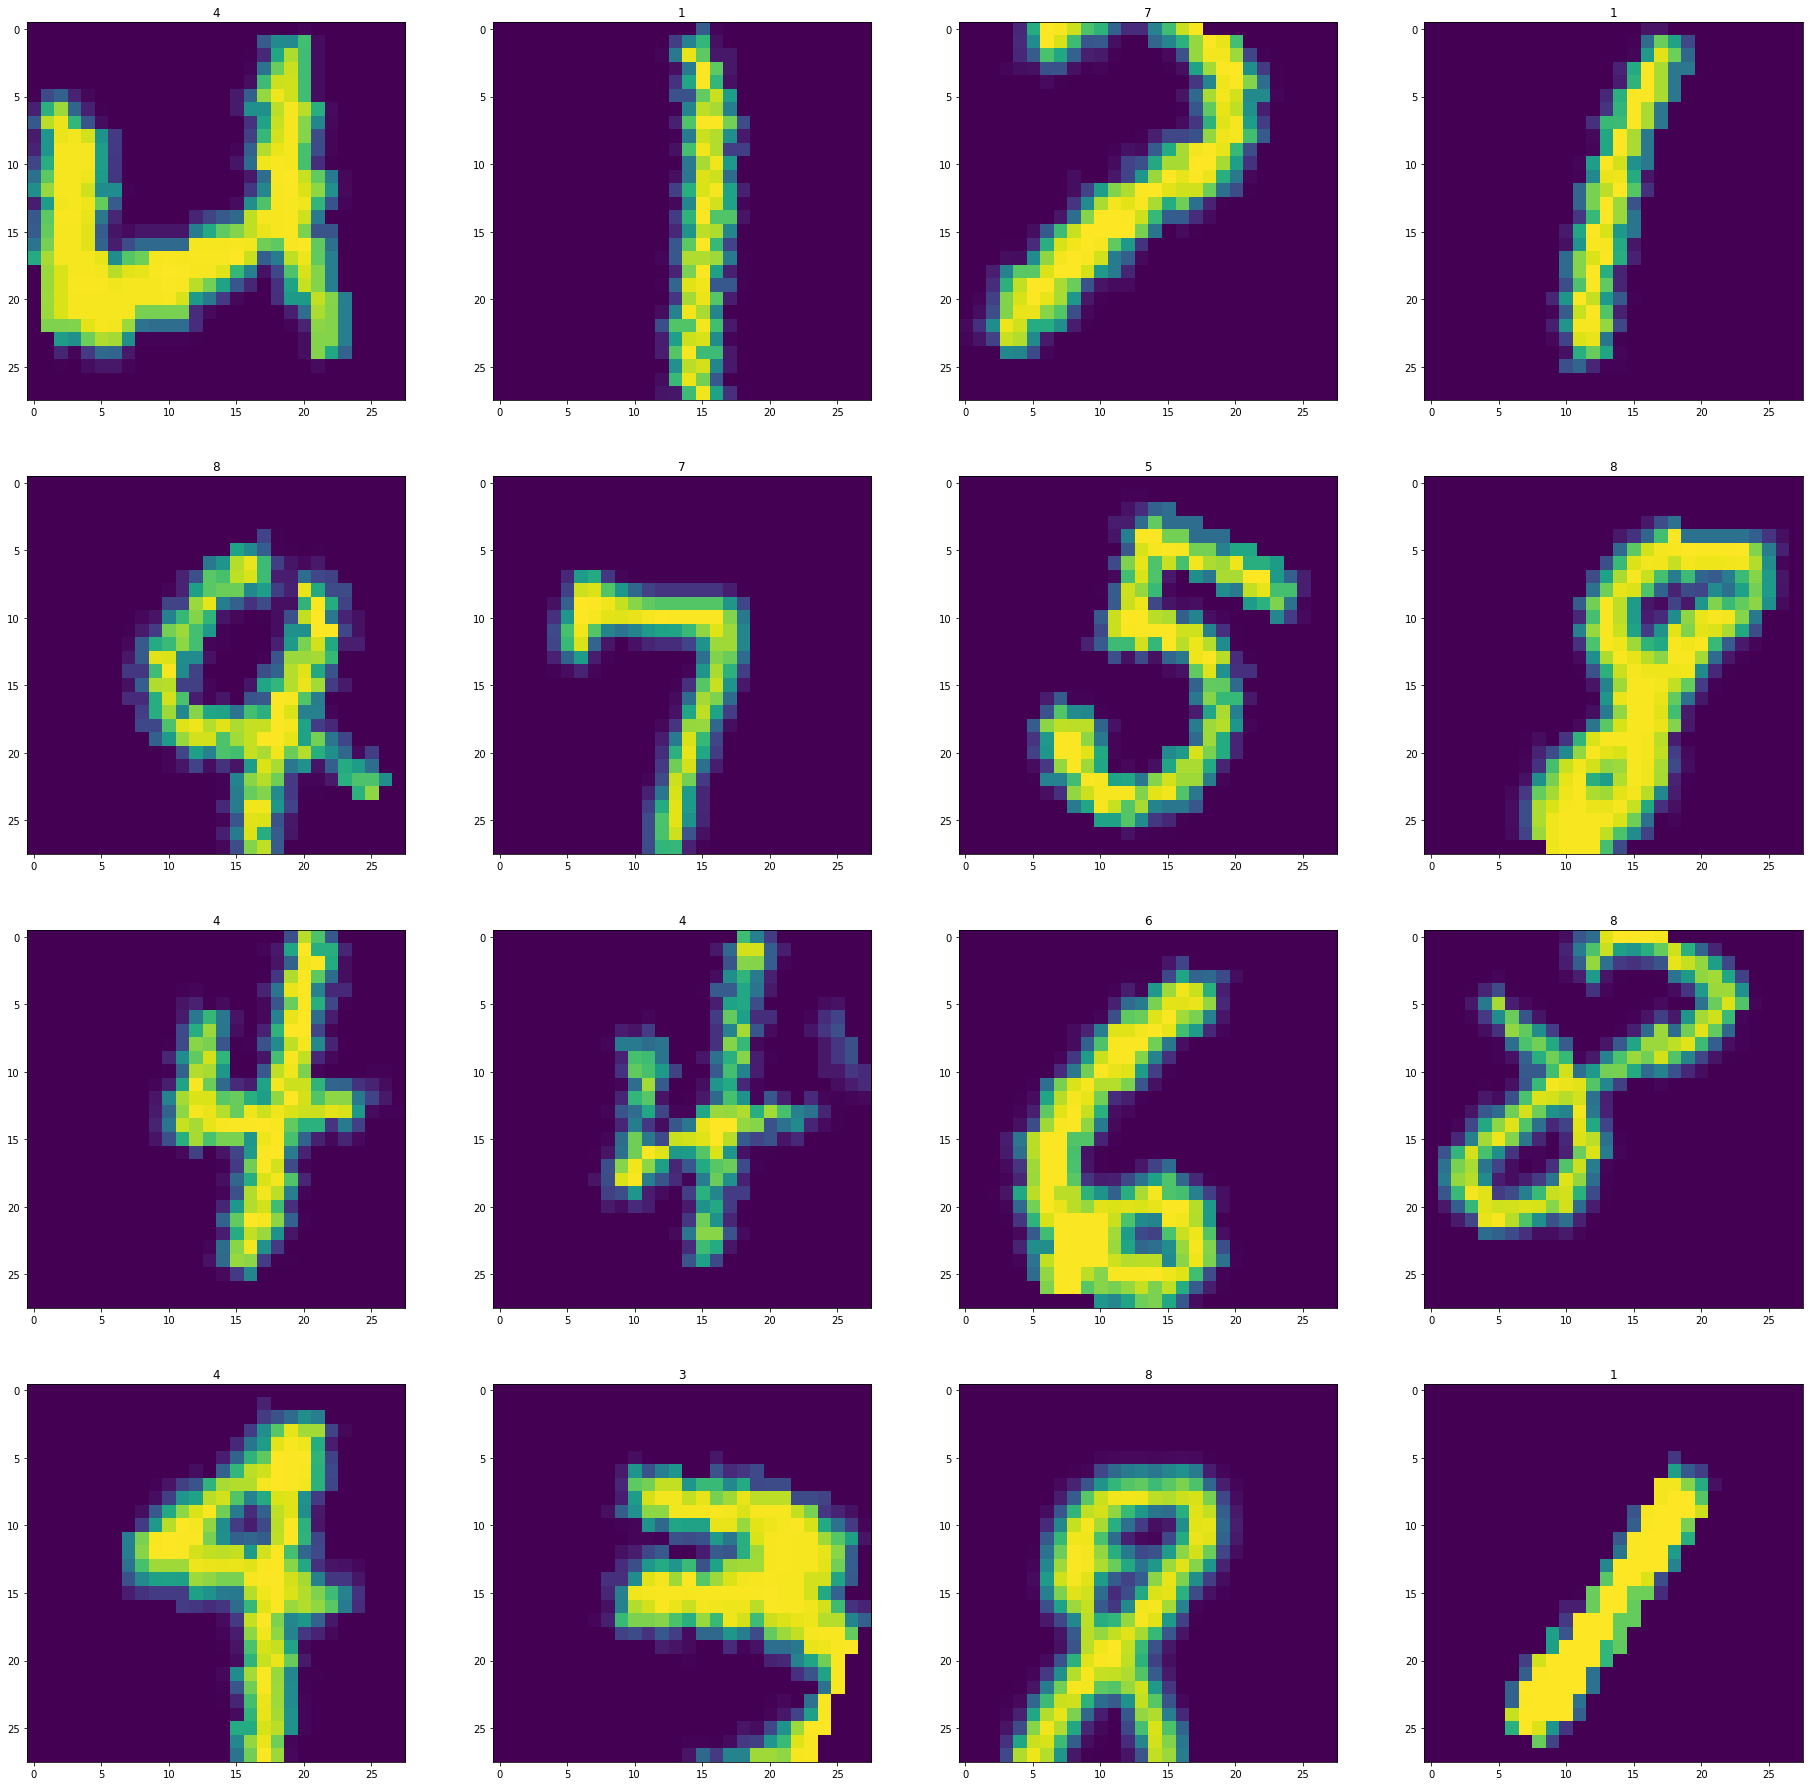

In [10]:
indices = np.random.randint(0, len(train_dataset), size=16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(32, 32))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*4+j]
        sample, label = train_dataset[sample_index]
        ax.imshow(sample.cpu().numpy().transpose(1, 2, 0).reshape(28,28))
        ax.set_title(label)

### Обучение модели

Теперь, когда мы реализовали модель и подготовили данные мы можем приступить к непосредственному обучению модели. Костяк функции обучения написан ниже, далее вы должны будете реализовать ключевые части этого алгоритма

In [11]:
def seed_worker(worker_id=0):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [12]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.001,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 30,
                early_stopping_patience = 5):
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, worker_init_fn=seed_worker)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, worker_init_fn=seed_worker)

    best_val_loss = None
    best_epoch = None
    
    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
        train_single_epoch(model, optimizer, loss_function, train_loader)
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return

### Задание 5

Реализуйте функцию, производящую обучение сети на протяжении одной эпохи ( полного прохода по всей обучающей выборке ). На вход будет приходить модель, оптимизатор, функция потерь и объект типа `DataLoader`. При итерировании по `data_loader` вы будете получать пары вида ( данные, целевая_переменная )

In [13]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    model.train()
    
    # Initialize the loss function
    loss_fn = loss_function
    size = len(data_loader.dataset)
    
    for batch, (X, y) in enumerate(data_loader):
        # Transfer to GPU
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Задание 6

Реализуйте функцию производящую вычисление функции потерь на валидационной выборке.  На вход будет приходить модель, функция потерь и `DataLoader`. На выходе ожидается словарь с вида:
```
{
    'loss': <среднее значение функции потерь>,
    'accuracy': <среднее значение точности модели>
}
```

In [14]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    model.eval()
    size = len(data_loader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in data_loader:
            # Transfer to GPU
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return {'loss': test_loss, 'accuracy': correct}

Если вы корректно реализовали все предыдущие шаги и ваша модель имеет достаточное количество обучаемых параметров, то в следующей ячейке должен пойти процесс обучения, и мы должны достичь итоговой точности (в смысле меры accuracy, доли верных ответов) выше 90%

In [15]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
_ = model.to(device)

In [17]:
# Проверим, где располагаеются параметры модели.
for param in model.parameters():
    print(param.device)
    break

cuda:0


In [18]:
loss_fn = torch.nn.CrossEntropyLoss()
train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.0001)

Epoch 0
loss: 2.311900  [    0/60000]
loss: 1.591312  [ 6400/60000]
loss: 1.532025  [12800/60000]
loss: 1.058578  [19200/60000]
loss: 1.157490  [25600/60000]
loss: 0.960833  [32000/60000]
loss: 1.156425  [38400/60000]
loss: 1.072036  [44800/60000]
loss: 0.820143  [51200/60000]
loss: 1.036511  [57600/60000]
Test Error: 
 Accuracy: 88.4%, Avg loss: 0.007224 

Validation metrics: 
{'loss': 0.00722353859692812, 'accuracy': 0.8841}
Best model yet, saving
Epoch 1
loss: 0.989248  [    0/60000]
loss: 1.017144  [ 6400/60000]
loss: 0.708193  [12800/60000]
loss: 0.531791  [19200/60000]
loss: 0.828382  [25600/60000]
loss: 0.666529  [32000/60000]
loss: 0.522393  [38400/60000]
loss: 0.316670  [44800/60000]
loss: 0.572585  [51200/60000]
loss: 0.572360  [57600/60000]
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.004527 

Validation metrics: 
{'loss': 0.004527176919579506, 'accuracy': 0.9242}
Best model yet, saving
Epoch 2
loss: 0.419897  [    0/60000]
loss: 0.670132  [ 6400/60000]
loss: 0.333631  [12800/

Проверим, действительно ли мы всё обучили и не обманывает ли наша выбранная метрика нас.     
Для этого применим модель вручную на отдельном кусочке данных.

Predicted: "7", Actual: "7"


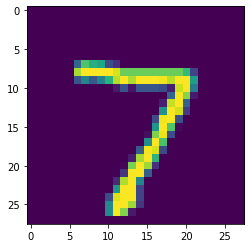

In [19]:
model.eval()
x, y = val_dataset[0][0].to(device), val_dataset[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = np.argmax(pred.cpu()), y
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
plt.imshow(val_dataset[0][0][0])

### Задание 7

Модифицируйте процесс обучения таким образом, чтобы достигнуть наилучшего качества на валидационной выборке. Модель должна оставаться N-слойным перцептроном с количеством обучаемых параметров <= 500000. Для обучения разрешается использовать только набор данных MNIST. Процесс обучения вы можете изменять по собственному усмотрению. К примеру, вы можете менять:

* Архитектуру модели в рамках наложенных ограничений на количество параметров и вид архитектуры (многослойный перцептрон)
* Функции активации в модели
* Используемый оптимизатор
* Расписание шага оптимизации
* Сэмплинг данных при обучении ( e.g. hard negative mining)

В результате мы ожидаем увидеть код экспериментов и любые инсайты, которые вы сможете получить в процессе

**Ответ**    
Выше можно наблюдать результат анализа возможных сочетаний параметров модели и обработки данных, который сочетает в себе высокую точность и малое количество итераций, за которое он приходит к этой точности. В основном цикле не был использован модуль tqdm как раз с целью показать, что уже за одну эпоху работы модели достигается точность ~90%. За 30 эпох точность доходит до 97.8%.     
<u> Конечные параметры:</u>    
Модель: `(784,256,256,10)` with ReLU  
Оптимизатор: `Adam`   
Расписание learning rate: `ReduceLROnPlateau`

Наблюдения в ходе экспериментирования с параметрами: 
* В ходе работы были проверены архитектурные композиции
                                  точность
          композиция    | на 1 эпохе | на 10 эпохе 
          with ReLU
      (784,256,256,10)  |     88%    |   97%
      (784,256,10)      |     86%    |   96%                 
      (784,512,128,10)  |     83%    |   88%    
      (784,10)          |     75%    |   81%

          with GELU
      (784,256,256,10)  |     89%    |   97%       
* Оставяя прочие параметры прежними и заменяя оптимизатор на `SGD`, скорость схождения модели уменьшится в разы: результат первой эпохи 13% accuracy, к десятой монотонно повышается до 37%. Как и ожидалось использование `Nesterov momentum` со значением `momentum`=0.9 значительно ускоряет схождение SGD, хотя всё ещё значительно проигрывает `Adam`. Результат первой эпохи: 36%, десятой эпохи: 81%  
* Легкие изменения/добавления аугментаций и обработок данных (например удаление нормализации данных, использование блюра) меняют скорость обучения не слишком сильно. Точность на каждом из поколений меняется в размере около 2%.   
* Однако можно приветси пример, как можно сломать обучение, использовав аугментации без должной осторожности,  - поставить в аугментацию вращение на угол 180 градусов. Это сильно замедляет обучение, потому что в тренировочной выборке теперь много объектов, которых нет в тестовой и стирает границу между 6-кой и 9-кой. Как итог - 53% на первой и 78% точности на десятой эпохе (при этом выше 80% точность уже не повышалась на протяжении 15 дополнительных эпох, так что какие-то ещё классы оказались частично совмещены в результате этой аугментации).  
* Такие расписания изменения learning rate, как `CosineAnnealingLR` и `MultiplicativeLR` дали такой же результат как и `ReduceLROnPlateau`. Можно предположить, что основной вклад в быструю сходимость даёт как раз использование оптимизатора `Adam`, и перформанс расписаний необходимо проверять с использованием какого-то иного оптимизатора.
* Использование hard negative mining счёл в рамках данной задачи избыточным, мне кажется он больше применим, когда мы хотим определить конкретный frame, где находится классифицируемый нами объект, кроме того, высокая точность достигается и без его использования.
* Визуализация с помощью TensorBoard была проведена в отдельном ноутбуке, тч опыт работы с ним тоже был получен.
* Better late than never.

     